In [31]:
import os
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanIoU
from tensorflow import keras


In [33]:
# Paths to images and labels
data_dir = "C:/Users/Eman/Downloads/images-20250217T060743Z-001/images"
labels_dir = "C:/Users/Eman/Downloads/labels-20250217T060744Z-001/labels"

In [35]:
# Load TIFF images (12-band) and PNG labels (binary mask)
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (12, 128, 128)
        image = np.transpose(image, (1, 2, 0))  # Convert to (128, 128, 12)
    return image / 255.0  # Normalize


In [37]:
# Normalize label images
def load_label(label_path):
    label = tf.keras.preprocessing.image.load_img(label_path, color_mode="grayscale")
    label = np.array(label, dtype=np.uint8)  # Convert to numpy array
    label = (label > 0).astype(np.int32)  # Ensure binary format
    return label

In [39]:
# Get sorted lists of image and label file paths
image_paths = sorted(glob(os.path.join(data_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(labels_dir, "*.png")))

# Debugging: Print number of images and labels
print(f"Total Images: {len(image_paths)}")
print(f"Total Labels: {len(label_paths)}")

# Ensure the number of images matches the number of labels
if len(image_paths) != len(label_paths):
    print("Error: Mismatch between images and labels!")
    exit()


Total Images: 306
Total Labels: 306


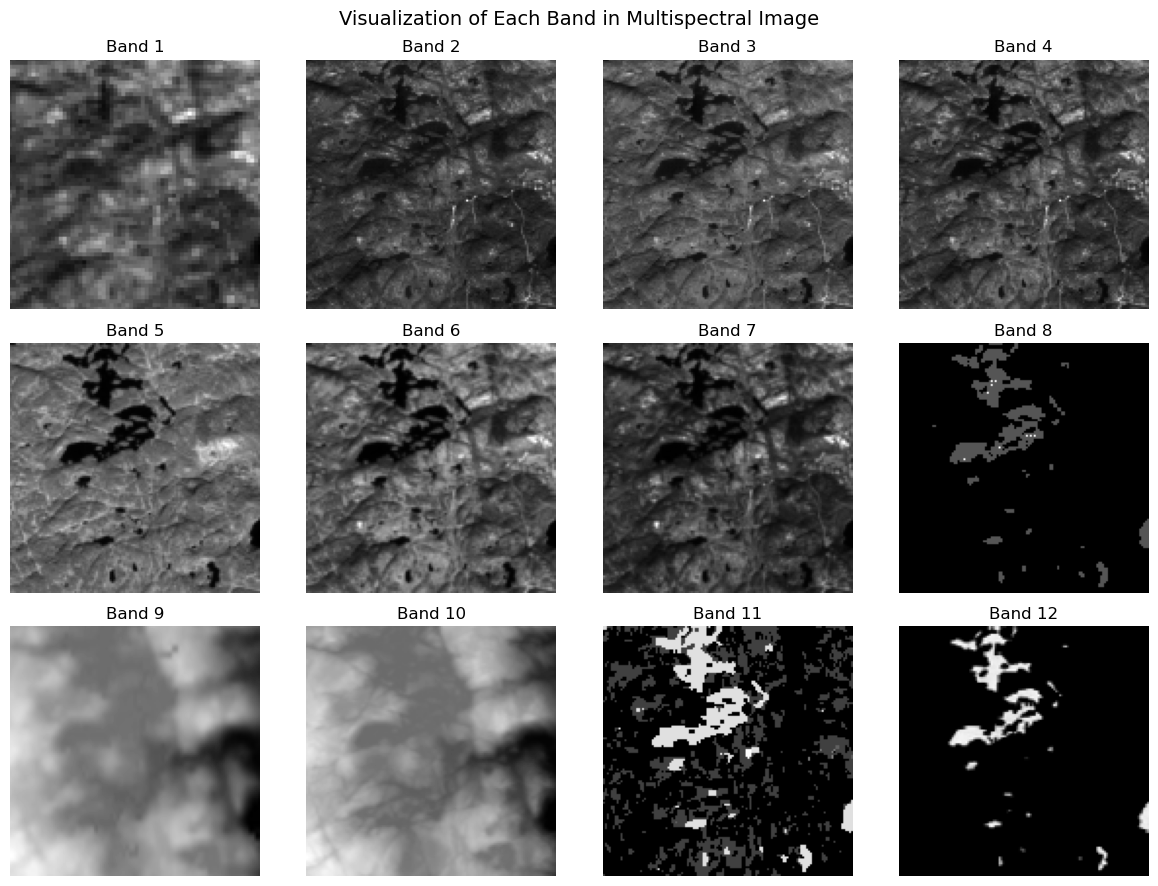

In [41]:
# Visualizing Each Band of a Sample Image
sample_image_path = image_paths[0]

with rasterio.open(sample_image_path) as src:
    sample_image = src.read().astype(np.float32)  # Shape: (12, 128, 128)

# Plot each band separately
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle("Visualization of Each Band in Multispectral Image", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < sample_image.shape[0]:  # Ensure within 12 bands
        ax.imshow(sample_image[i], cmap='gray')
        ax.set_title(f'Band {i+1}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [43]:
# Split dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(
    image_paths, label_paths, test_size=0.2, random_state=42
)

print(f"Training Samples: {len(train_images)}, Testing Samples: {len(test_images)}")


Training Samples: 244, Testing Samples: 62


In [45]:
# Build U-Net model
def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (Contracting Path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.5)(p1)  # Dropout to prevent overfitting

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.5)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder (Expanding Path)
    u1 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    #u1 = layers.Dropout(0.5)(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    #u2 = layers.Dropout(0.5)(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [47]:
# Initialize model
model = build_unet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 12)      │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 128, 128, 64)      │           6,976 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 128, 128, 64)      │          36,928 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 64, 64, 64)        │               0 │ conv2d_10[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64, 64, 64)        │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 64, 64, 128)       │          73,856 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 64, 64, 128)       │         147,584 │ conv2d_11[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 32, 32, 128)       │               0 │ conv2d_12[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32, 32, 128)       │               0 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 32, 32, 256)       │         295,168 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 32, 32, 256)       │         590,080 │ conv2d_13[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_2            │ (None, 64, 64, 128)       │         295,040 │ conv2d_14[0][0]            │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 64, 64, 256)       │               0 │ conv2d_transpose_2[0][0],  │
│                               │                           │                 │ conv2d_12[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 64, 64, 128)       │         295,040 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_3            │ (None, 128, 128, 64)      │          73,792 │ conv2d_15[0][0]            │
│ (Conv2DTranspose)             │                           │               

 Total params: 1,888,321 (7.20 MB)

 Trainable params: 1,888,321 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Prepare dataset for training
def preprocess_data(image_paths, label_paths):
    images = np.array([load_image(p) for p in image_paths])
    labels = np.array([load_label(p) for p in label_paths])
    labels = np.expand_dims(labels, axis=-1)  # Add channel dimension
    return images, labels

train_images_np, train_labels_np = preprocess_data(train_images, train_labels)
test_images_np, test_labels_np = preprocess_data(test_images, test_labels)

In [53]:
# Train model
model.fit(train_images_np, train_labels_np, epochs=30, batch_size=8, validation_data=(test_images_np, test_labels_np))


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9244 - loss: 0.2071 - val_accuracy: 0.9217 - val_loss: 0.1968
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9156 - loss: 0.2126 - val_accuracy: 0.9206 - val_loss: 0.2068
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9211 - loss: 0.2168 - val_accuracy: 0.9217 - val_loss: 0.1963
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9244 - loss: 0.1912 - val_accuracy: 0.9231 - val_loss: 0.1973
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9233 - loss: 0.2039 - val_accuracy: 0.9213 - val_loss: 0.1947
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9109 - loss: 0.2149 - val_accuracy: 0.9215 - val_loss: 0.1928
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9236 - loss: 0.1904 - val_accuracy: 0.9245 - val_loss: 0.1867
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9214 - loss: 0.1999 - val_accuracy: 0.9249 - val_loss:

In [55]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    iou = MeanIoU(num_classes=2)
    iou.update_state(y_true, y_pred)
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    
    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / \
               (precision.result().numpy() + recall.result().numpy() + 1e-7)
    
    print(f"IoU: {iou.result().numpy():.4f}, Precision: {precision.result().numpy():.4f}, "
          f"Recall: {recall.result().numpy():.4f}, F1-score: {f1_score:.4f}")

In [57]:
# Predict and evaluate
predictions = (model.predict(test_images_np) > 0.5).astype(np.int32)
evaluate_model(test_labels_np, predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
IoU: 0.8239, Precision: 0.9251, Recall: 0.7720, F1-score: 0.8417
